# Visual Question Answering (VQA)
This notebook implements a multi-modal architecture for VQA based on the DAQUAR dataset introduced here: [DAQUAR dataset](https://www.mpi-inf.mpg.de/departments/computer-vision-and-machine-learning/research/vision-and-language/visual-turing-challenge/)

The objective of this project is to merge two modalities: Images + Text and build an AI that can answer questions about images.

In [10]:
# Imports

import os
import numpy as np
import torch
import torch.nn as nn

from PIL import Image
from pathlib import Path
from datasets import load_dataset
from IPython.display import display

from sklearn.metrics import accuracy_score, f1_score

from transformers import CLIPVisionModel, CLIPImageProcessor, DistilBertModel

# Set up device agnostic code

device = torch.device('cuda' if torch.cuda.is_available() else ('mps' if torch.mps.is_available() else 'cpu'))
print(f"Using device: {device}")

Using device: mps


## Dataset

The processed version of the dataset used in this project can be downloaded from Kaggle [here](https://www.kaggle.com/datasets/tezansahu/processed-daquar-dataset/data). Also contains the original dataset files.

### Original dataset
The original dataset has 3 files:
- `all_qa_pairs.txt`
- `train_images_list.txt`
- `test_images_list.txt`

### Processed dataset

The processed version dataset contains a processed version of the full DAQUAR dataset, with the following descriptions:
- `data.csv`: Processed dataset after normalizing all the questions and conversting the data into a tabular format {question, answer, image_id}
- `data_train.csv`: Training data from `train_images_list.txt`
- `data_eval.csv`: Testing data from `test_images_list.txt`
- `answer_space.txt`: List of all possible answers extracted from `all_qa_pairs.txt`

In [3]:
# Set up directory paths

PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data"
IMG_DIR = DATA_DIR / "images"

TRAIN_CSV = DATA_DIR / "data_train.csv"
EVAL_CSV = DATA_DIR / "data_eval.csv"
ANS_TXT = DATA_DIR / "answer_space.txt"

for p in [DATA_DIR, IMG_DIR, TRAIN_CSV, EVAL_CSV, ANS_TXT]:
    assert p.exists(), f"Missing: {p}"

In [4]:
# Load CSVs + answer space and add labels

ds = load_dataset(
    "csv",
    data_files={"train": str(TRAIN_CSV), "test":str (EVAL_CSV)}
)

# answer space
answers = [line.strip().lower() for line in ANS_TXT.read_text(encoding="utf-8").splitlines() if line.strip()]
ans_to_idx = {a: i for i, a in enumerate(answers)}

if "<unk>" not in ans_to_idx:
    ans_to_idx["<unk>"] = len(ans_to_idx)
    answers.append("<unk>")

def _norm(a: str) -> str:
    return str(a).strip().lower()

# take the first answer in case there are multiple answers
def _to_label(a_raw: str) -> int: 
    first = _norm(a_raw.split(",")[0])
    return ans_to_idx.get(first, ans_to_idx["<unk>"])

ds = ds.map(lambda b: {"label": [_to_label(a) for a in b["answer"]]}, batched=True)

def _resolve_path(image_id: str) -> str:
    from os.path import exists
    stem = image_id if image_id.endswith(".png") else f"{image_id}.png"
    p = IMG_DIR / stem
    if not p.exists():
        raise FileNotFoundError(f"Not found: {p}")
    return str(p)

ds = ds.map(lambda ex: {"image_path": _resolve_path(ex["image_id"])})
print(ds)



DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'image_id', 'label', 'image_path'],
        num_rows: 9974
    })
    test: Dataset({
        features: ['question', 'answer', 'image_id', 'label', 'image_path'],
        num_rows: 2494
    })
})


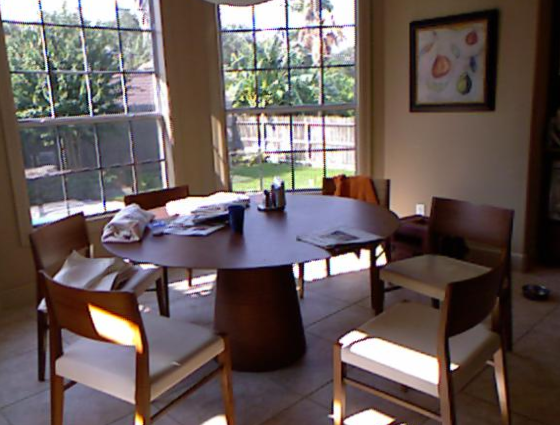

Q: how many windows found to the opposite of the table
A: 2
label id: 10



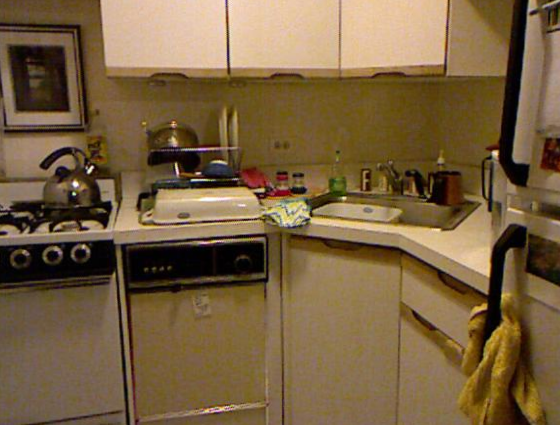

Q: what is the close to the counter
A: sink
label id: 445



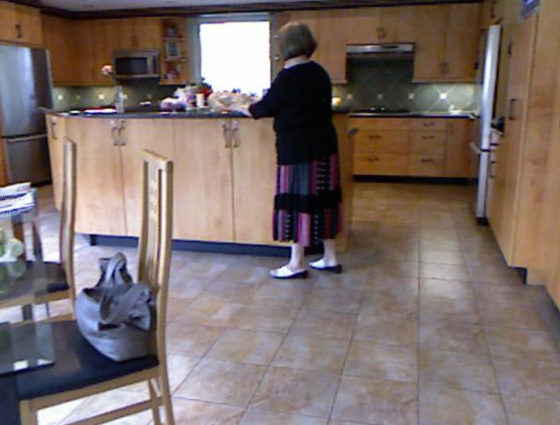

Q: what is the object found on the right corner of the room
A: oven
label id: 355



In [5]:
# preview data sample

def preview_sample(split="train", idx=None, n=1):
    data = ds[split]
    for _ in range(n):
        i = np.random.randint(len(data)) if idx is None else idx
        ex = data[i]
        img = Image.open(ex["image_path"]).convert("RGB")
        display(img)
        print("Q:", ex["question"])
        print("A:", ex["answer"])
        print("label id:", ex["label"])
        print()

preview_sample("train", n=3)

In [ ]:
# sanity checks

# missing files?
missing = [ex["image_id"] for ex in ds["train"] if not Path(ex["image_path"]).exists()]
print("missing images: ", len(missing))

# how long are questions? (to pick max_length later)
lens = [len(str(ex["question"]).split()) for ex in ds["train"]]
print("min/median/max question len (words): ", min(lens), np.median(lens), max(lens))

# number of answer classes
n_classes = len(set(ds["train"]["label"]))
print("classes present in train: ", n_classes)

missing images:  0
min/median/max question len (words):  3 7.0 24
classes present in train:  525


## Model with Cross-Attention

- CLIPVisionModel (ViT) for image tokens
- DistilBertModel for question tokens
- Cross-Attention block
- Classifier head (over `answer_space`)

In [ ]:
class CrossAttentionBlock(nn.Module):
    """
    Single multi-head cross-attention:
        queries = text tokens (B, T, D)
        keys/vals = image tokens (B, I, D)
    Uses torch.nn.MultiheadAttention under the hood.
    """

    def __init__(self, d_model: int, n_heads: int, dropout: float = 0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=n_heads, dropout=dropout, batch_first=True)
        self.ln1 = nn.LayerNorm(d_model)
        self.mlp = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.GELU(),
            nn.Linaer(4 * d_model, d_model),
            nn.Dropout(dropout),
        )
        self.ln2 = nn.LayerNorm(d_model)

    def forward(self, q_text, kv_image, key_padding_mask=None):
        """
        q_text: (B, T, D)
        kv_image: (B, I, D)
        key_padding_mask: optional (B, I) mask for image tokens (False for valid, True for pad)
        """

        # cross-attention (residual + norm)
        attn_out, _ = self.attn(q_text, kv_image, key_padding_mask=key_padding_mask, need_weights=False)
        x = self.ln1(q_text + attn_out)
        # feed forward
        x = self.ln2(x + self.mlp(x))
        return x
    

class VQACrossAttn(nn.Module):
    """
    Image encoder (CLIP ViT) + Text encoder (DistilBERT) + Cross-Attention + Classifier
    - D is the shared feature dim
    - Supports precomputed image tokens for caching
    """

    def __init__(
            self,
            num_classes: int,
            vision_model_name: str = "openai/clip-vit-base-path32",
            text_model_name: str = "distilbert-base-uncased",
            d_model: int = 512,     # shared hidden size after projection
            n_heads: int = 8,
            dropout: float = 0.1,
            freeze_vision: bool = True,
            freeze_text: bool = True,
            pool: str = "cls",      # "cls" or "mean"
    ):
        super().__init__()

        # encoders
        self.vision = CLIPVisionModel.from_pretrained(vision_model_name)
        self.text = DistilBertModel.from_pretrained(text_model_name)
        self.vision_processor = CLIPImageProcessor.from_pretrained(vision_model_name)

        # encoder output dims
        d_img = self.vision.config.hidden_size
        d_txt = self.text.config.dim

        # projections to shared space D
        self.proj_img = nn.Linear(d_img, d_model)
        self.proj_txt = nn.Linear(d_txt, d_model)

        # fusion
        self.cross_atn = CrossAttentionBlock(d_model=d_model, n_heads=n_heads, dropout=dropout)

        # classifier
        self.pool = pool
        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, num_classes)
        )

        # freeze encoders initially
        if freeze_vision:
            for p in self.vision.parameters():
                p.requires_grad = False
        if freeze_text:
            for p in self.text.parameters():
                p.requires_grad = False

In [ ]:
# Image feature Path (supports caching)

@torch.no_grad()
def encode_images(self, pixel_values: torch.Tensor):
    """
    pixel_values: (B, 3, H, W), preprocessed to CLIP format (using CLIPImageProcessor)
    returns image_tokens: (B, I, D)
    """
    #CLIPVisionModel expects pixel_values to be normalized
    out = self.vision(pixel_values=pixel_values)
    img_tokens = out.last_hidden_state                  # (B, I, d_img)
    img_tokens = self.proj_img(img_tokens)              # (B, I , D)

    return img_tokens

def encode_text(self, input_ids, attention_mask):
    """
    input_ids: (B, T), attention_mask: (B, T)
    returns text_tokens: (B, T, D)
    """
    out = self.text(input_ids=input_ids, attention_mask=attention_mask)
    txt_tokens = out.last_hidden_state              # (B, T, d_txt)
    txt_tokens = self.proj_txt(txt_tokens)          # (B, T, D)

def forward(
        self,
        input_ids = None,
        attention_mask = None,
        pixel_values = None,
        image_tokens = None,
        labels = None
):
    """
    returns dict(logits, loss, image_tokens)
    """
    